In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
T = transforms.ToTensor()
dataset = datasets.MNIST(root='../dataset',transform=T, train=True, download=False)
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=64,
                                        shuffle=True)

In [4]:
dataiter = iter(dataloader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))
print(images.shape)
print(images.reshape(-1, 28*28).shape)

tensor(0.) tensor(1.)
torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [7]:
NUM_EPOCHS = 30
outputs = []
for epoch in range(NUM_EPOCHS):
    for (img, _) in dataloader:
#         img = img.view(-1, 28*28)
        recon = model(img.to(DEVICE))
        loss = criterion(recon.to('cpu'), img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0084
Epoch:2, Loss:0.0066
Epoch:3, Loss:0.0035
Epoch:4, Loss:0.0031
Epoch:5, Loss:0.0029
Epoch:6, Loss:0.0029
Epoch:7, Loss:0.0028
Epoch:8, Loss:0.0025
Epoch:9, Loss:0.0030
Epoch:10, Loss:0.0028
Epoch:11, Loss:0.0023
Epoch:12, Loss:0.0026
Epoch:13, Loss:0.0028
Epoch:14, Loss:0.0024
Epoch:15, Loss:0.0025
Epoch:16, Loss:0.0027
Epoch:17, Loss:0.0026
Epoch:18, Loss:0.0025
Epoch:19, Loss:0.0024
Epoch:20, Loss:0.0026
Epoch:21, Loss:0.0026
Epoch:22, Loss:0.0030
Epoch:23, Loss:0.0025
Epoch:24, Loss:0.0027
Epoch:25, Loss:0.0027
Epoch:26, Loss:0.0027
Epoch:27, Loss:0.0028
Epoch:28, Loss:0.0026
Epoch:29, Loss:0.0027
Epoch:30, Loss:0.0027


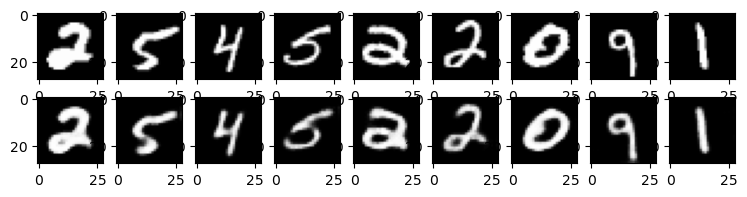

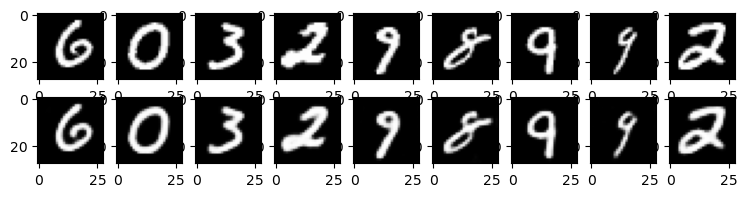

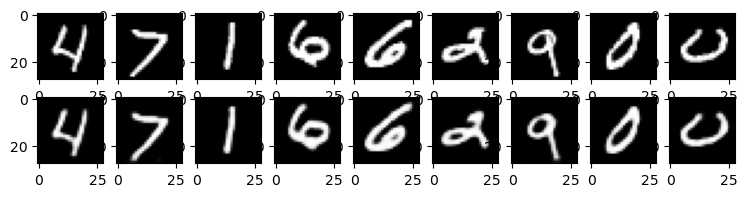

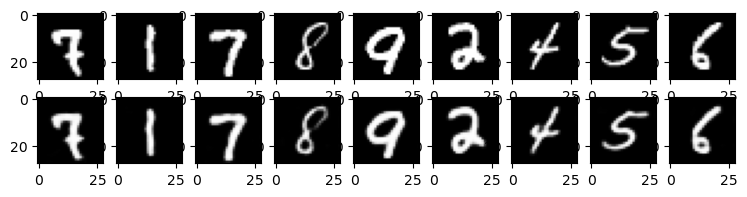

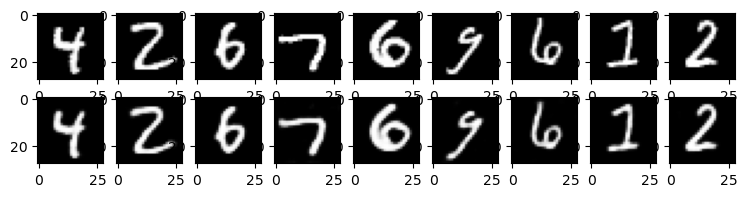

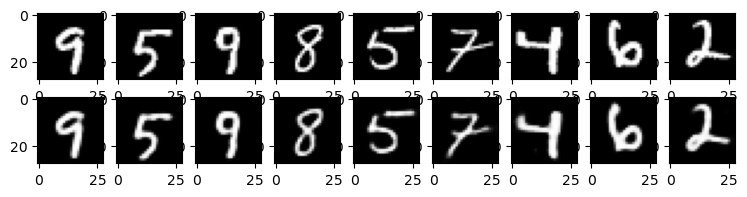

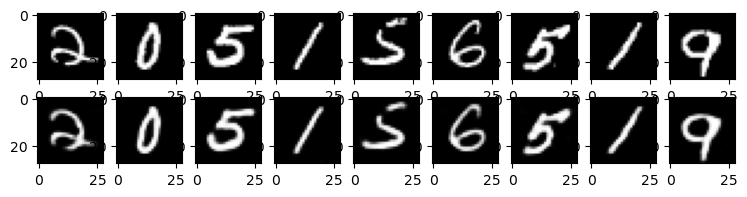

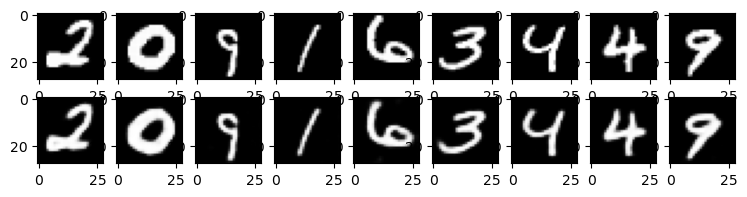

In [9]:
for k in range(0, NUM_EPOCHS, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].to('cpu').detach().numpy()
    recon = outputs[k][2].to('cpu').detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28,28)
        plt.imshow(item[0])